In [101]:
import pickle
import os
import pandas as pd
from tqdm import tqdm
from src.models import *
from src.constants import *
from src.plotting import *
from src.pot import *
from src.utils import *
from src.diagnosis import *
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
from time import time
from pprint import pprint
from datetime import datetime, timedelta
from preprocess import normalize3
from main import  convert_to_windows, load_dataset, load_model, backprop
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams["text.usetex"] = False
plt.rcParams['figure.figsize'] = 8, 5

def find_closest_row(df, input_date):
    """
    Finds the row in the DataFrame with the closest `Start Time` or `End Time` to the given input date.

    Parameters:
    - df (pd.DataFrame): The DataFrame with 'Start Time' and 'End Time' columns.
    - input_date (str): The input date as a string in the format 'YYYY-MM-DD HH:MM:SS'.

    Returns:
    - pd.Series: The closest row in the DataFrame.
    """
    # Convert input date to a datetime object
    input_date = pd.to_datetime(input_date)
    
    # Ensure 'Start Time' and 'End Time' are datetime
    df['Start Time'] = pd.to_datetime(df['Start Time'])
    df['End Time'] = pd.to_datetime(df['End Time'])
    
    # Find the absolute time difference with input_date for both columns
    df['Time Difference'] = df[['Start Time', 'End Time']].apply(
        lambda x: min(abs((x['Start Time'] - input_date).total_seconds()), 
                      abs((x['End Time'] - input_date).total_seconds())), axis=1
    )
    
    # Get the row with the minimum time difference
    closest_row = df.loc[df['Time Difference'].idxmin()]
    
    # Drop the helper column before returning
    df.drop(columns=['Time Difference'], inplace=True)
    
    return closest_row

def add_time_series_noise(data, noise_level=0.001):
    df_no_timestamp = torch.tensor(data)

    window_size=360
    noisy_data = []
    for start in range(0, len(df_no_timestamp), window_size):
        window = df_no_timestamp[start:start + window_size]

        feature_noise_scale = noise_level * window.abs()
        noise = feature_noise_scale * torch.randn(window.shape, device=window.device)
        noisy_window = window + noise
        noisy_data.append(noisy_window)

    noisy_data = torch.cat(noisy_data, dim=0).numpy()
    return noisy_data

feature_set = ['Active Power', 'Governor speed actual',
       'Opening Wicked Gate', 'Penstock Flow', 'Turbine flow',
       'Penstock pressure', 'Governor Penstock Pressure', 'UGB X displacement',
       'UGB Y displacement', 'LGB X displacement', 'LGB Y displacement',
       'TGB X displacement', 'TGB Y displacement',
       'Stator winding temperature 13', 'Stator winding temperature 14',
       'Stator winding temperature 15',
       'Surface Air Cooler Air Outlet Temperature',
       'Surface Air Cooler Water Inlet Temperature',
       'Surface Air Cooler Water Outlet Temperature',
       'Stator core temperature', 'UGB metal temperature',
       'LGB metal temperature 1', 'LGB metal temperature 2',
       'LGB oil temperature', 'UGB cooling water flow',
       'LGB cooling water flow', 'Generator cooling water flow',
       'UGB Oil Contaminant', 'Gen Thrust Bearing Oil Contaminant']

df_data_withtime = pd.read_pickle("/run/media/fourier/Data2/Pras/Vale/time-series-autoencoder/my_data_5thn_olah.pickle")
mask = (df_data_withtime['TimeStamp'] >= '2020-01-01 00:00:00')
df_data_withtime = df_data_withtime.loc[mask]

for column_name in df_data_withtime.columns:
    if column_name != 'Load_Type' and column_name != 'TimeStamp':
        df_data_withtime[column_name] = pd.to_numeric(df_data_withtime[column_name], downcast='float')
        
df_anomaly = pd.read_excel("/run/media/fourier/Data2/Pras/Vale/time-series-autoencoder/shutdown_list.xlsx", 'Sheet2')
df_anomaly['Start Time'] = pd.to_datetime(df_anomaly['Start Time'])
df_anomaly['End Time'] = pd.to_datetime(df_anomaly['End Time'])
df_anomaly_unplaned = df_anomaly.copy()

mask = (df_anomaly_unplaned['Interal/External'] == 'Internal') & (df_anomaly_unplaned['Shutdown Type'] == 'Unplanned') & (df_anomaly_unplaned['Start Time'] >= '2020-01-01 00:00:00')
df_anomaly_unplaned = df_anomaly_unplaned.loc[mask]
df_anomaly_unplaned = df_anomaly_unplaned.reset_index(drop=True)
df_anomaly_unplaned

dataset_folder = 'data/Custom2'
df_train = pd.read_csv(os.path.join(dataset_folder, 'train.csv'))
df_test = pd.read_csv(os.path.join(dataset_folder, 'test.csv'))
df_train, df_test = df_train.values[:, 1:], df_test.values[:, 1:]
_, min_a, max_a = normalize3(np.concatenate((df_train, df_test), axis=0))

In [120]:
df_anomaly_unplaned

,Start Time,End Time,Event,Activities,Related Component,Action/Cause,Interal/External,Shutdown Details,Startup Details,Supplied Grid after Action,Shutdown Type
0,2023-05-22 20:13:00,2023-05-22 20:32:00,LGS#1 Trip by 86N energized,Mechanical,TGB Oil Level,Repairment,Internal,Trip by 86 N Alarm,Flying Started,FCE Grid,Unplanned
1,2022-03-26 10:07:00,2022-03-26 13:50:00,LGS#1 Trip by 86N energized,Mechanical,Rotor Shaft Current at Lower Generator,Repairment,Internal,Trip by 86N Alarm to Standstill,Start via 4/CS,FCE Grid,Unplanned
2,2022-03-26 16:17:00,2022-03-26 22:28:00,LGS#1 suddenly trip by 86N due to Rotor shaft ...,Mechanical,Rotor Shaft Current at Lower Generator,Repairment,Internal,Trip by 86N Alarm to Standstill,Start,-,Unplanned
3,2021-05-28 06:15:00,2021-05-30 00:58:00,LGS#1 Trip by 86N energized,Mechanical,TGB Cooling Water,Repairment,Internal,Trip by 86N Alarm,Started via 4/CS,FCE Grid,Unplanned


Loading pre-trained model: Attention


/run/media/fourier/Data2/Pras/Vale/TN_Anom/DTAAD/main.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fname)


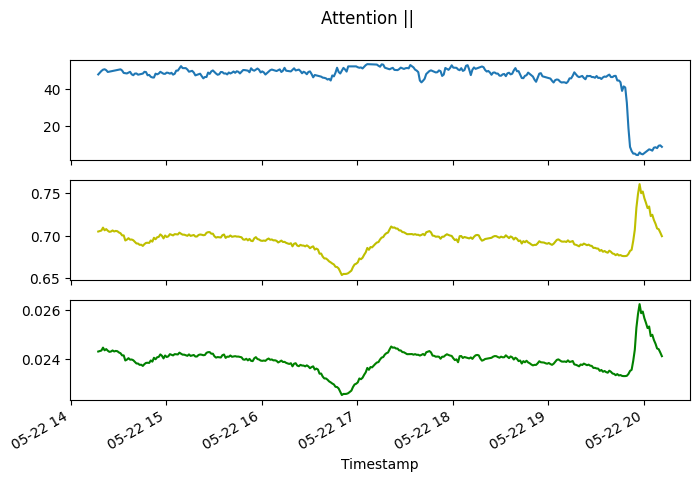

In [125]:
model_list = ['Attention'] #['Attention', 'CAE_M', 'GDN', 'MTAD_GAT', 'MAD_GAN', 'DTAAD']

for model_now in model_list:
    args.model = model_now
    model, optimizer, scheduler, epoch, accuracy_list = load_model(args.model, len(feature_set))
    torch.zero_grad = True
    model.to(torch.device('cpu'))
    model.eval()
    #print(f'{color.HEADER}Testing {args.model} on {args.dataset}{color.ENDC}')

    failure_index_list = 0
    index_before = 0

    # pd.Timestamp("2023-01-24 00:00:00") - pd.Timedelta(minutes=1)
    end_date_filter = df_anomaly_unplaned.values[failure_index_list, 0] + timedelta(minutes=0) - timedelta(minutes=(100 * index_before) + 1)
    start_date_filter =  end_date_filter - timedelta(minutes=60 * 6 * 1)

    mask = (df_data_withtime['TimeStamp'] > start_date_filter.strftime('%Y-%m-%d %H:%M:%S')) & (df_data_withtime['TimeStamp'] <= end_date_filter.strftime('%Y-%m-%d %H:%M:%S'))
    df_sel = df_data_withtime.loc[mask]
    df_sel = df_sel.reset_index(drop=True)
    df_timestamp = df_sel.iloc[:, 0]
    df_feature =  df_sel.iloc[:, 1:]
    df_feature = df_feature[feature_set]
    raw_active = df_feature['Active Power'].values

    df_feature = add_time_series_noise(df_feature.values)
    df_feature, _, _ = normalize3(df_feature, min_a, max_a)
    df_feature = df_feature.astype(float)

    test_loader = DataLoader(df_feature, batch_size=df_feature.shape[0])
    testD = next(iter(test_loader))
    testO = testD

    if model.name in ['Attention', 'DAGMM', 'USAD', 'MSCRED', 'CAE_M', 'GDN', 'MTAD_GAT', 'MAD_GAN', 'TranAD'] or 'DTAAD' in model.name:
        testD = convert_to_windows(testD, model)

    data = testD
    dataO = testO

    loss, y_pred = backprop(0, model, testD, testO, optimizer, scheduler, training=False)
    if 'TranAD' or 'DTAAD' in model.name: testO = torch.roll(testO, 1, 0)

    y_true = testO.cpu().detach().numpy()[5:, :]
    y_pred = y_pred[5:, :]
    ascore = loss[5:, :]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    ax1.plot(df_timestamp.values[5:], raw_active[5:])

    ax2.plot(df_timestamp.values[5:], smooth(np.sum(ascore, axis=-1)), color='y', label='sum')
    #ax2.axhline(y=0.002,c="red")

    ax3.plot(df_timestamp.values[5:], smooth(np.mean(ascore, axis=-1)), color='g', label='Score')

    shutdown_str = ''
    for _, anomaly in df_anomaly.iterrows():
        start = anomaly['Start Time']
        end = anomaly['End Time']
        anomaly_type = anomaly['Interal/External']

        # Only plot if the anomaly is in the current month
        if start <= end_date_filter and end >= start_date_filter:
            if start <= start_date_filter:
                start = start_date_filter

            if end >= end_date_filter:
                end = end_date_filter

            if anomaly['Shutdown Type'] == 'Unplanned':
                if anomaly_type == 'Internal':
                    ax1.axvspan(start, end, color='red', alpha=0.6, label=f'{anomaly["Shutdown Type"]} Shutdown Area')
                elif anomaly_type == 'External':
                    ax1.axvspan(start, end, color='gray', alpha=0.8, label=f'{anomaly["Shutdown Type"]} Shutdown Area')
            elif anomaly['Shutdown Type'] == 'Planned':
                ax1.axvspan(start, end, color='purple', alpha=0.6, label=f'{anomaly_type} Shutdown Area')
            shutdown_str = anomaly['Event']

    ax3.set_xlabel('Timestamp')
    plt.gcf().autofmt_xdate()
    #ax2.set_ylim([0, 1])
    fig.suptitle(f'{model_now} || {shutdown_str}')
    fig.show()

In [126]:
contributions = ascore[-180:, :] / np.sum(ascore, axis=-1)[-180:, np.newaxis]
overall_contributions = np.mean(contributions, axis=0)

ranked_indices = np.argsort(overall_contributions)[::-1]  # Sort descending
rankings = [(i+1, idx, overall_contributions[idx]) for i, idx in enumerate(ranked_indices)]

print("Sensor Rankings (Overall Contribution):")
for rank, sensor_idx, contribution in rankings:
    print(f"Rank {rank}: Sensor {feature_set[sensor_idx]} with contribution {contribution:.2f}")

    if rank >= 4:
        break

Sensor Rankings (Overall Contribution):
Rank 1: Sensor Stator winding temperature 13 with contribution 0.62
Rank 2: Sensor UGB Oil Contaminant with contribution 0.08
Rank 3: Sensor Surface Air Cooler Water Outlet Temperature with contribution 0.07
Rank 4: Sensor LGB oil temperature with contribution 0.04


/tmp/ipykernel_758878/1433470612.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)


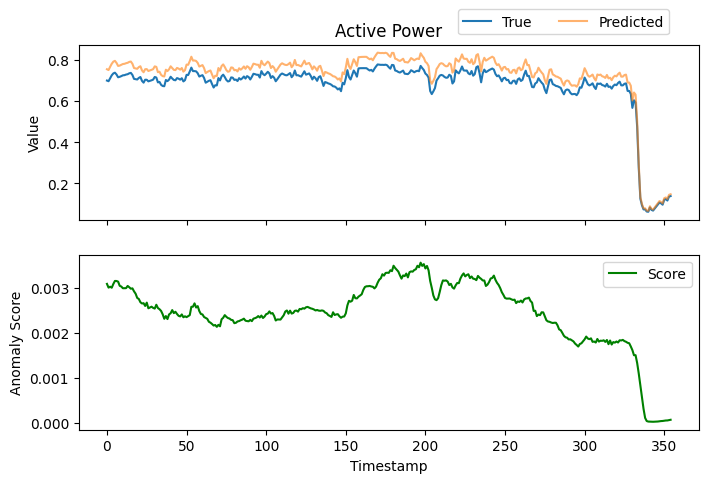

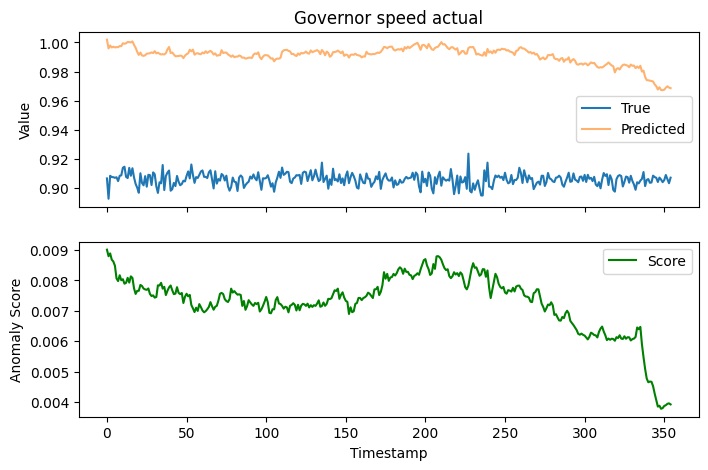

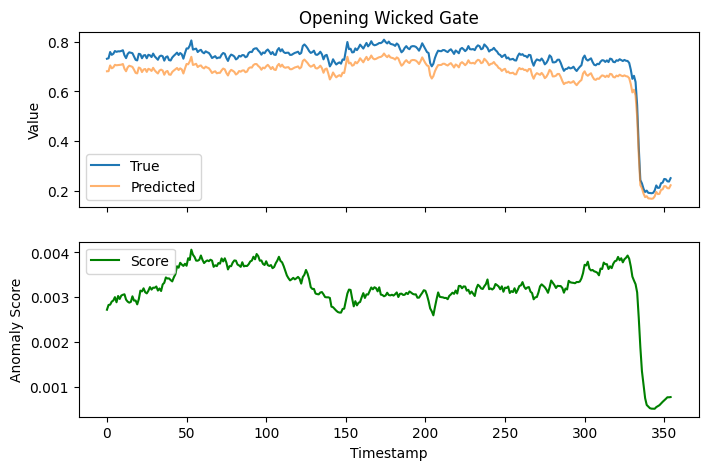

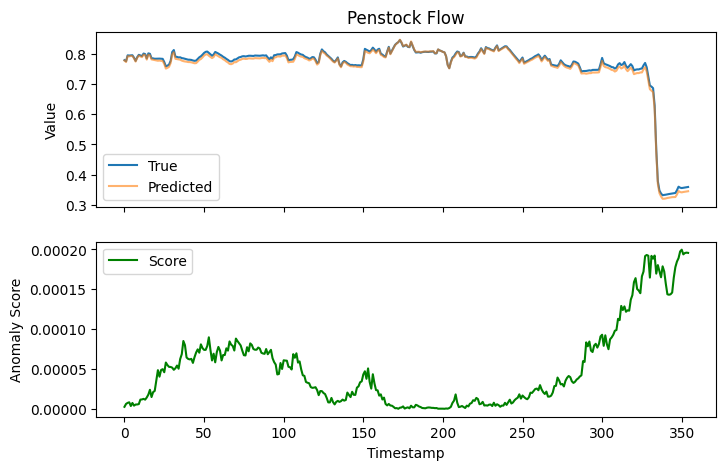

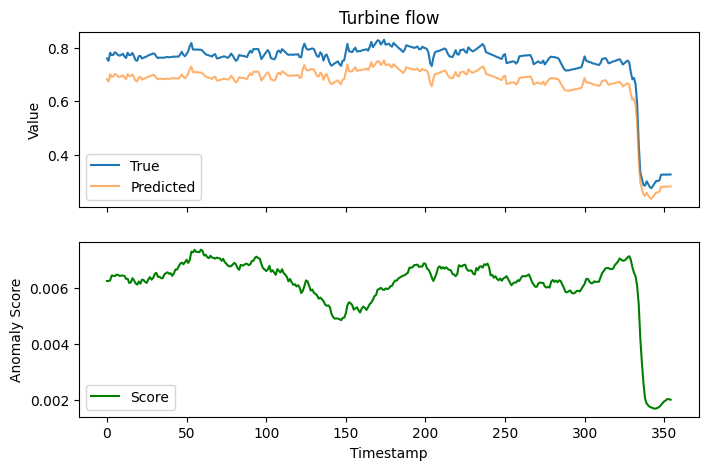

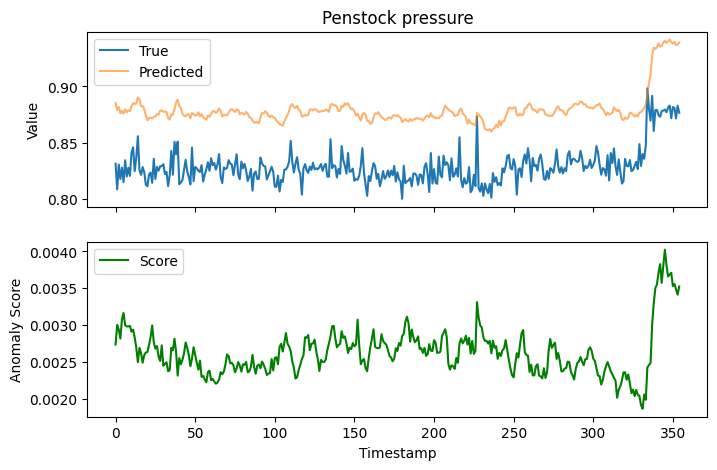

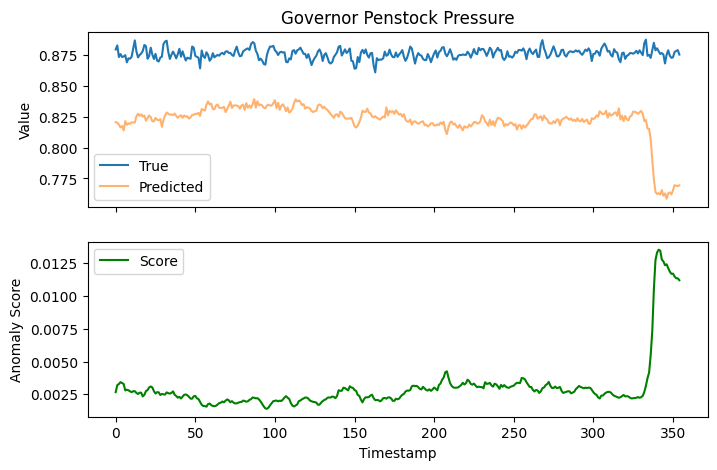

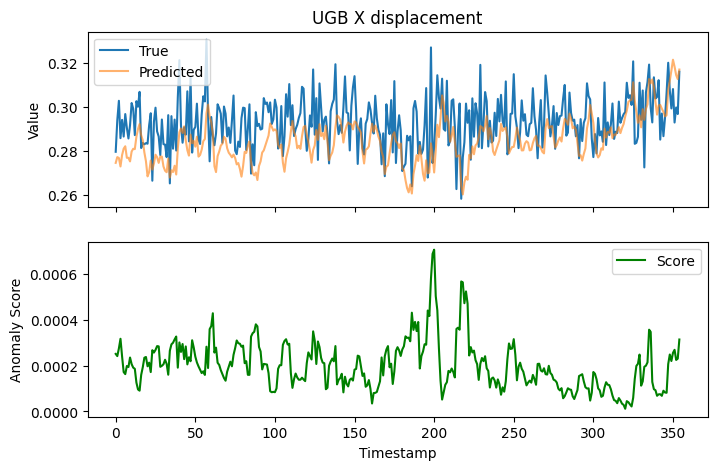

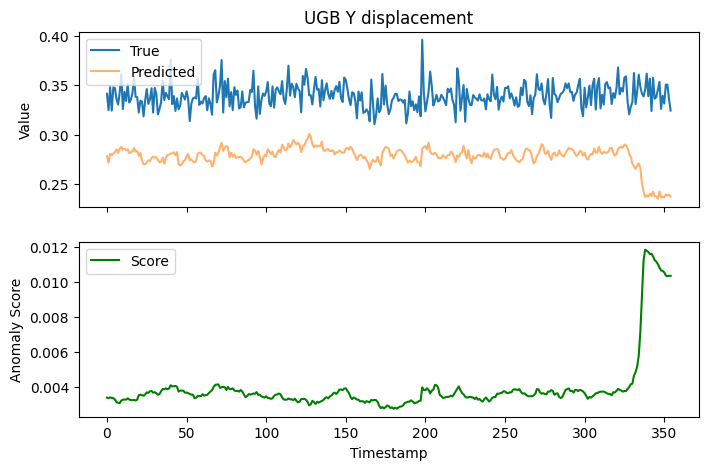

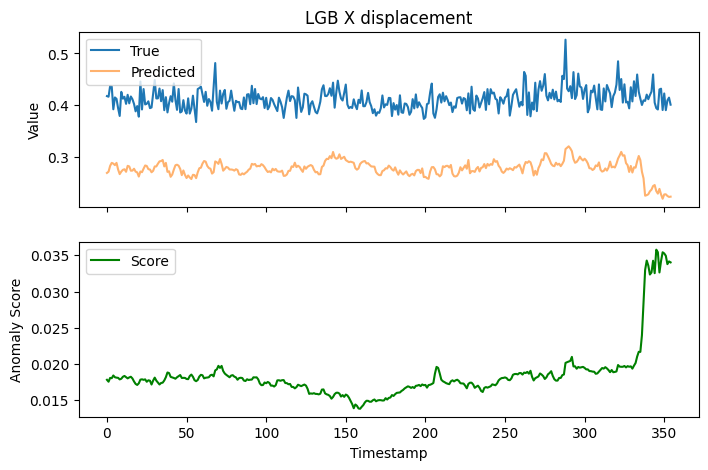

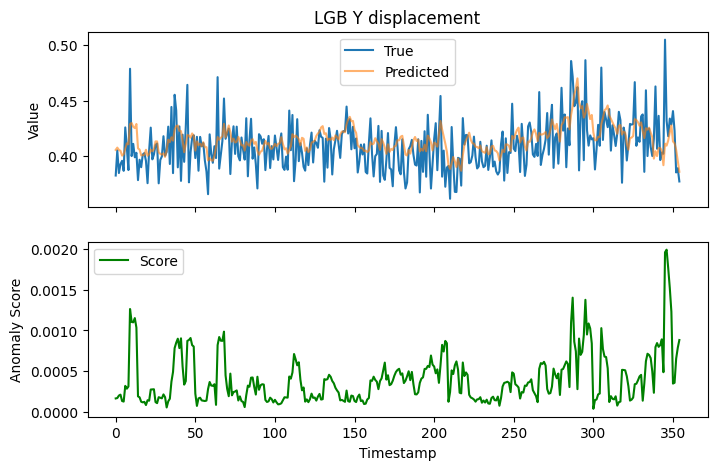

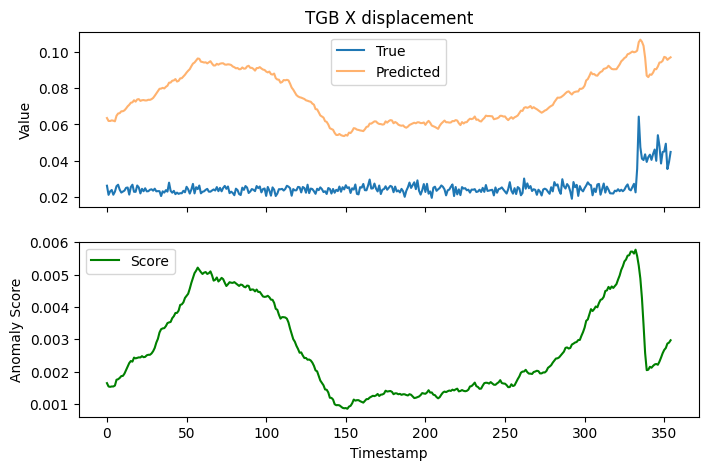

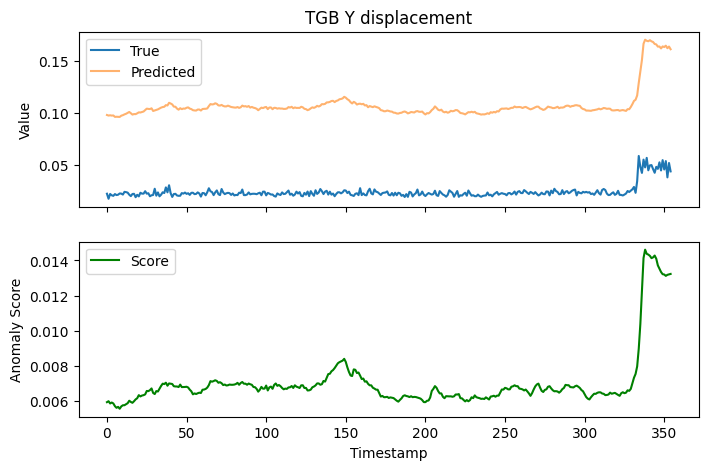

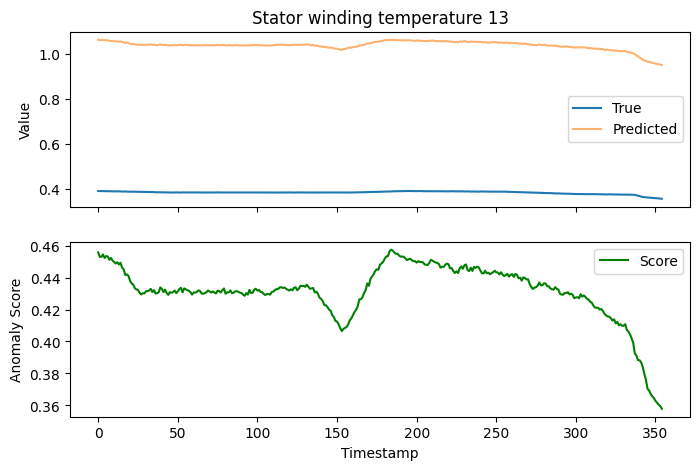

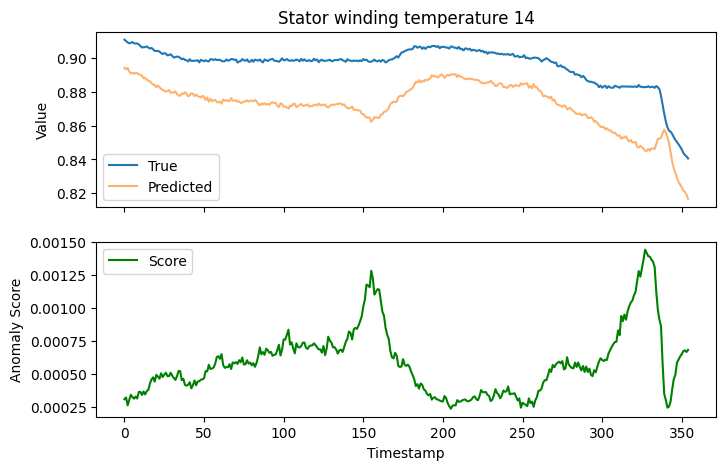

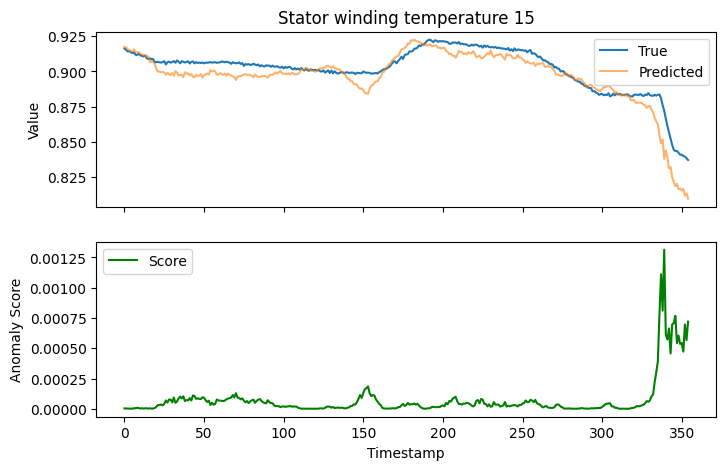

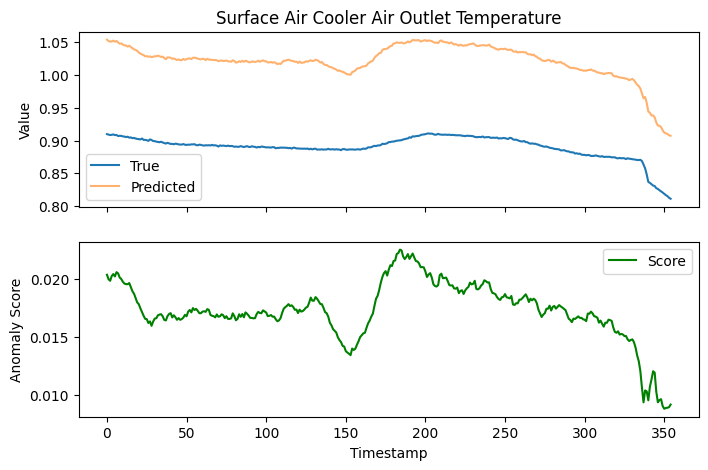

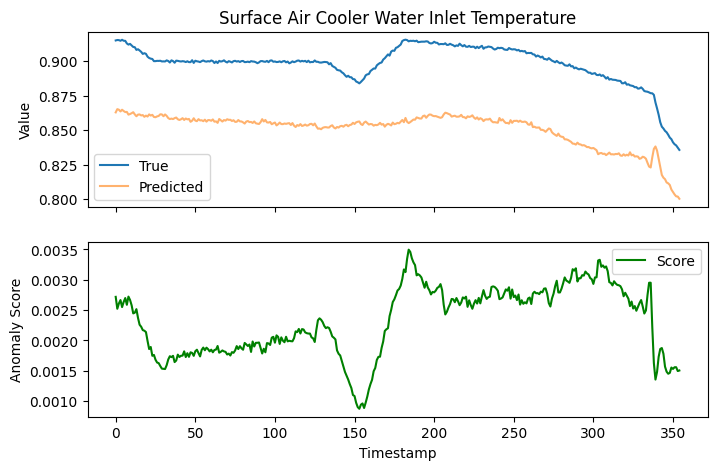

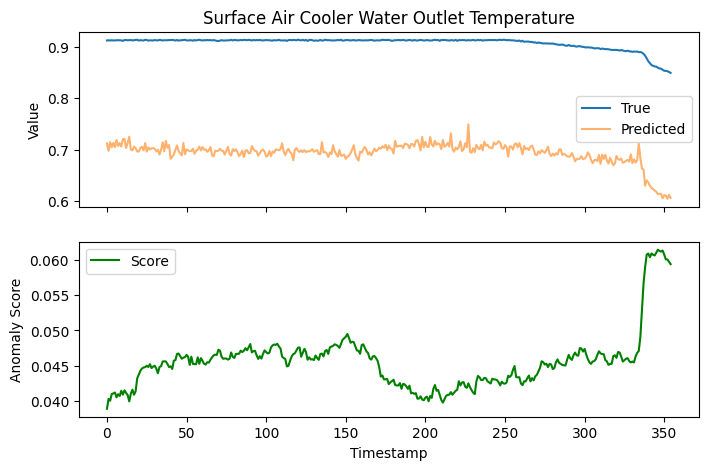

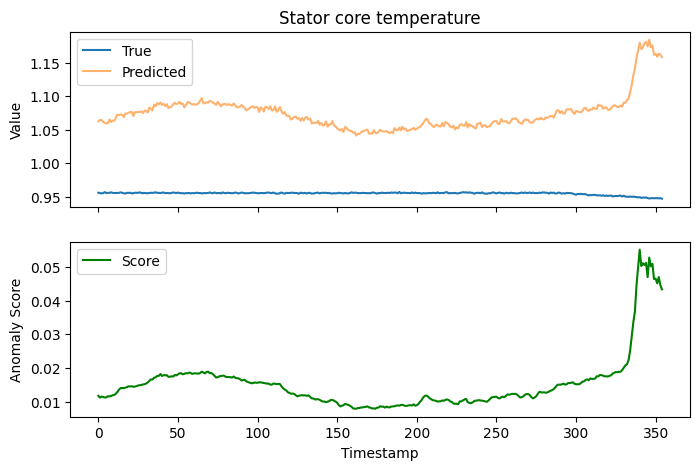

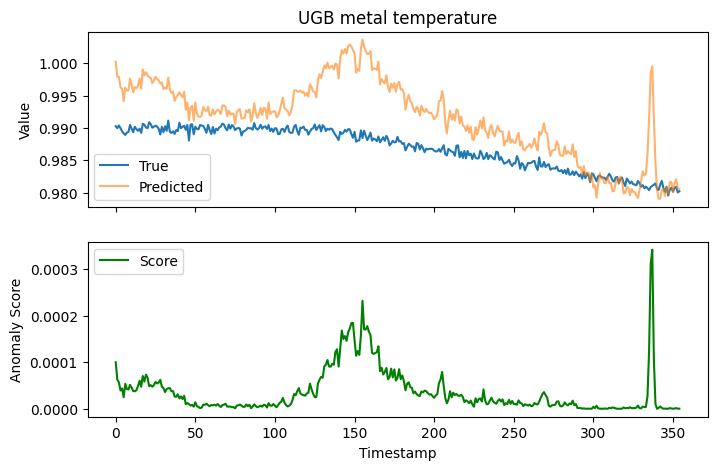

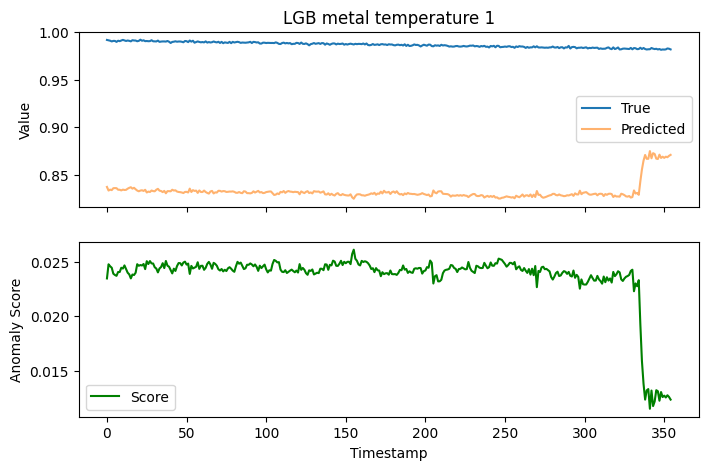

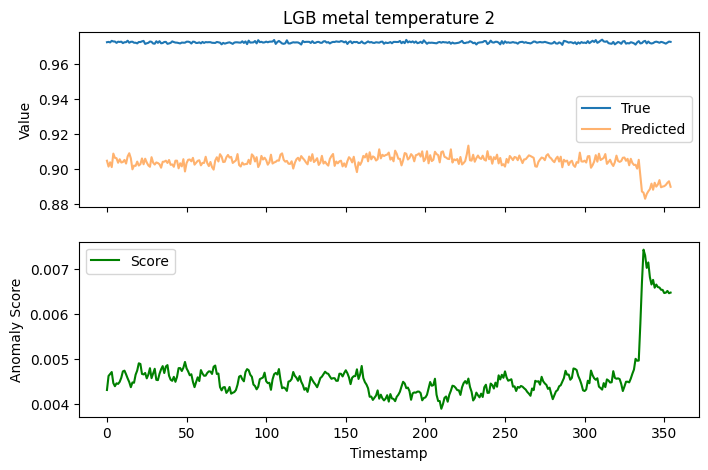

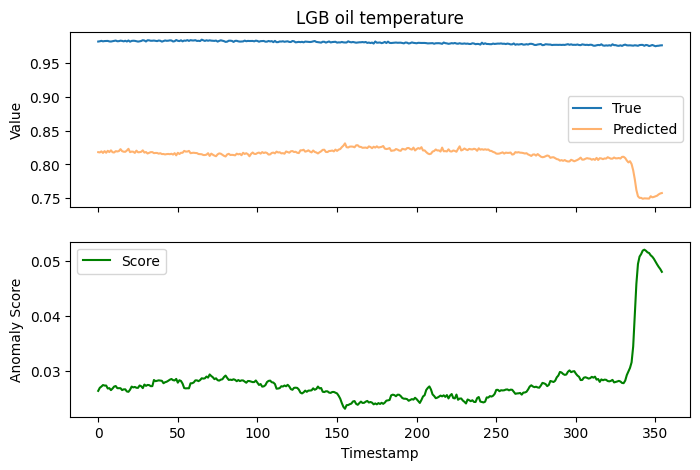

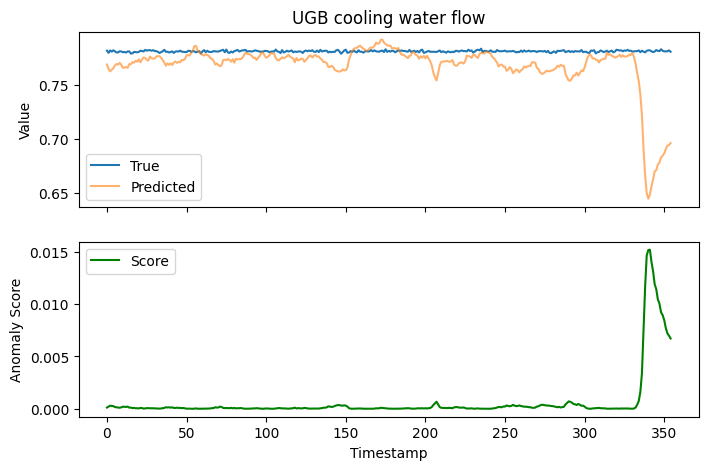

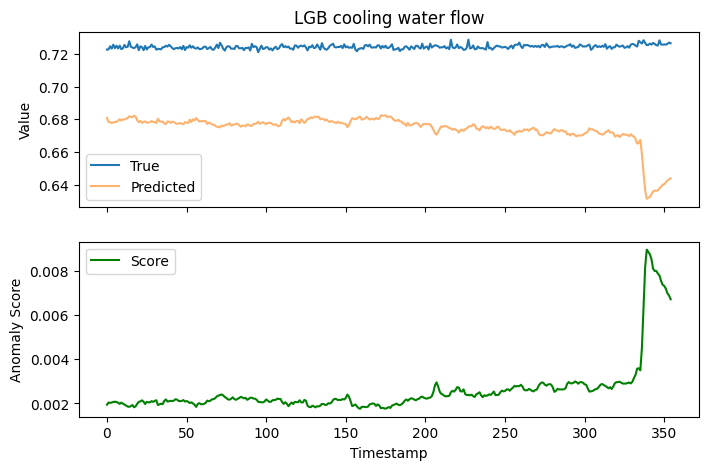

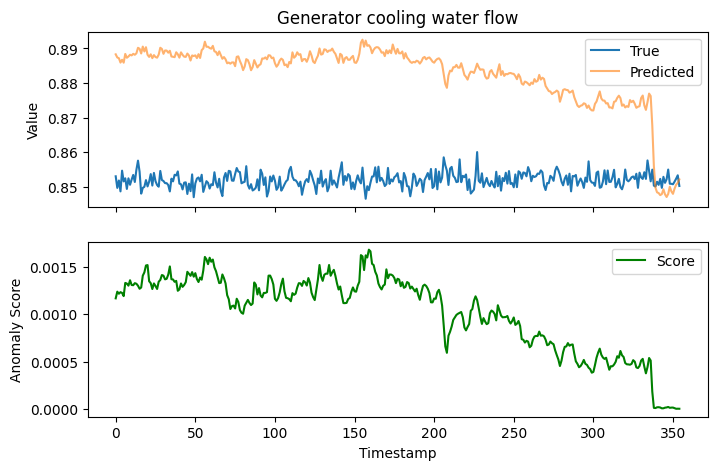

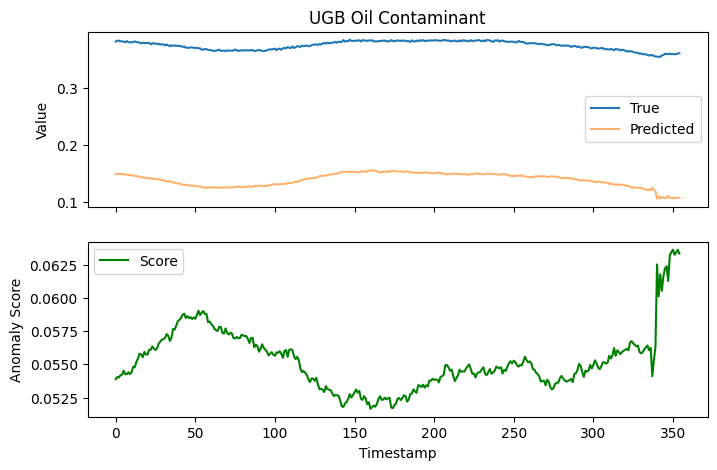

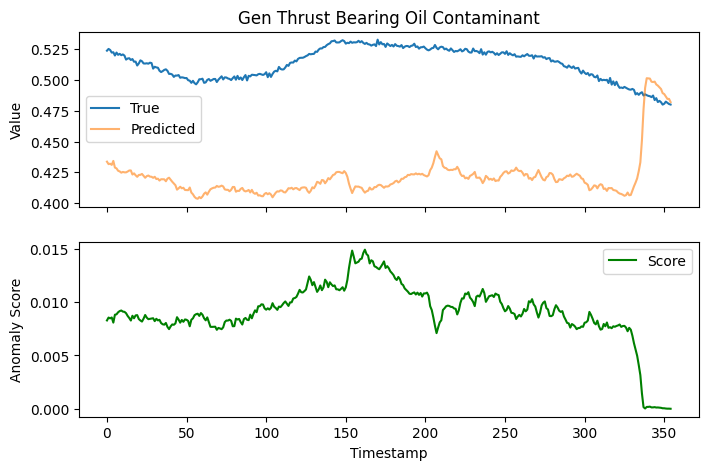

In [127]:
for dim in range(y_true.shape[1]):
    y_t, y_p, a_s = y_true[:, dim], y_pred[:, dim], ascore[:, dim]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.set_ylabel('Value')
    ax1.set_title(f'{feature_set[dim]}')

    ax1.plot(smooth(y_t), label='True')
    ax1.plot(smooth(y_p), '-', alpha=0.6, label='Predicted')
    ax1.legend()

    if dim == 0: ax1.legend(ncol=2, bbox_to_anchor=(0.6, 1.02))
    ax2.plot(smooth(a_s), color='g', label='Score')
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Anomaly Score')
    ax2.legend()
    #ax2.set_ylim([0, 1])
    #ax1.set_yticks([])
    #ax2.set_yticks([])

In [58]:
    for dim in range(y_true.shape[1]): # y_true.shape[1]
        y_t, y_p, l, a_s = y_true[:, dim], y_pred[:, dim], labels[:, 0], ascore[:, dim]
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        ax1.set_ylabel('Value')
        ax1.set_title(f'Dimension = {dim}')
        # if dim == 0: np.save(f'true{dim}.npy', y_t); np.save(f'pred{dim}.npy', y_p); np.save(f'ascore{dim}.npy', a_s)
        ax1.plot(smooth(y_t), linewidth=0.2, label='True')
        ax1.plot(smooth(y_p), '-', alpha=0.6, linewidth=0.3, label='Predicted')
        ax3 = ax1.twinx()
        # ax3.plot(l, '--', linewidth=0.3, alpha=0.5)
        ax3.fill_between(np.arange(l.shape[0]), l, color='blue', alpha=0.3, label='True Anomaly')
        # ax3.fill_between(np.nonzero(l)[0], 0, l[np.nonzero(l)], color='blue', alpha=0.3, label='Anomaly')
        if dim == 0: ax1.legend(ncol=2, bbox_to_anchor=(0.6, 1.02))
        # ax[0, 0].legend(ncol=2, bbox_to_anchor=(0.6, 1.02))
        ax2.plot(smooth(a_s), linewidth=0.2, color='g', label='Score')
        ax4 = ax2.twinx()
        # ax4.plot(l, '--', linewidth=0.3, alpha=0.5)
        # ax4.fill_between(np.nonzero(l)[0], 0, l[np.nonzero(l)], color='red', alpha=0.3, label='Predicted Anomaly')
        ax4.fill_between(np.arange(l.shape[0]), l, color='red', alpha=0.3, label='Predicted Anomaly')
        if dim == 0: ax4.legend(bbox_to_anchor=(1, 1.02))
        # ax22.legend(bbox_to_anchor=(1, 1.02))
        ax2.set_xlabel('Timestamp')
        ax2.set_ylabel('Anomaly Score')
        ax1.set_yticks([])
        ax2.set_yticks([])
        pdf.savefig(fig)
        plt.close()
        # plt.savefig(f'plots/{name}/output.svg')

NameError: name 'labels' is not defined

NameError: name 'y_orig' is not defined

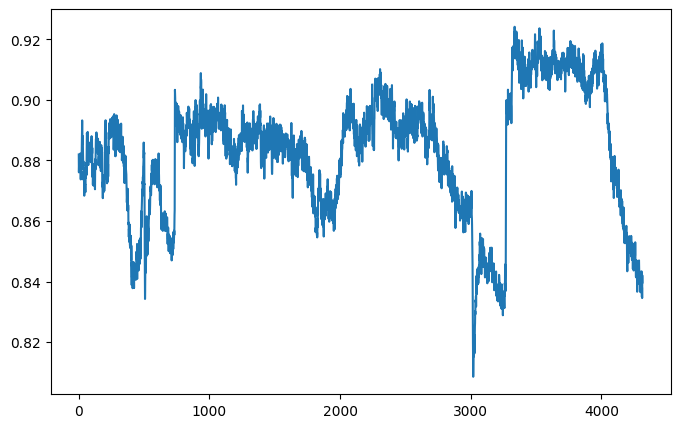

In [59]:
feature_index = 6
plt.plot(y_pred[:, feature_index])
plt.plot(y_orig[:, feature_index])
plt.show()

In [77]:
y_orig.shape

(100, 29)

In [5]:
l = nn.MSELoss(reduction='none')
model.to(torch.device(args.Device))
model = model.to('cuda:0')
n = epoch + 1



In [12]:
data.shape

torch.Size([104026, 841])

In [24]:
y_pred.shape

torch.Size([1, 29])

In [26]:
d.shape[0] // 29

29

In [11]:
data.shape

torch.Size([104026, 841])

In [ ]:
# loss, y_pred = backprop(0, model, testD, testO, optimizer, scheduler, training=False)
# backprop(epoch, model, data, dataO, optimizer, scheduler, training=True):

In [9]:
d.shape

torch.Size([104026, 29])

In [10]:
feats = testO.shape[1]
l = nn.MSELoss(reduction='none')
_lambda = 0.8
model.to(torch.device(args.Device))
data_x = torch.DoubleTensor(testD)
dataset = TensorDataset(data_x, data_x)
bs = len(testD)
dataloader = DataLoader(dataset, batch_size=bs)
n = epoch + 1
w_size = model.n_window
l1s, l2s = [], []

model.to(torch.device('cpu'))
for d, _ in dataloader:
    window = d.permute(0, 2, 1)
    elem = window[:, :, -1].view(1, bs, feats)
    z = model(window)
    z = z[1].permute(1, 0, 2)
    break
loss = l(z, elem)[0]

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [6]:
window.shape

NameError: name 'window' is not defined

In [20]:
elem.shape

torch.Size([1, 104026, 29])

In [21]:
z.shape

torch.Size([1, 104026, 29])